In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from load_data import get_adata
from utils import create_model_dir
from sc_condition_prediction import create_and_train_vae_model, validate_r2, evaluate_r2, N_INPUT, N_LAYERS, N_HIDDEN, N_LATENT, BATCH_SIZE

import warnings
warnings.filterwarnings('ignore')

# Initialize constants
load_dotenv()
CONDITION_KEY, CELL_TYPE_KEY, CONTROL_KEY, STIMULATED_KEY = os.getenv('CONDITION_KEY'), \
                                                            os.getenv('CELL_TYPE_KEY'), \
                                                            os.getenv("CONTROL_KEY"), \
                                                            os.getenv("STIMULATED_KEY")

# Load data
adata = get_adata(dataset="train_kang")

Global seed set to 0
/Users/danorel/Workspace/Education/University/Toronto/vaegen/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/danorel/Workspace/Education/University/Toronto/vaegen/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Control unit

In [2]:
USE_CUSTOM = True
VERBOSE = True

In [3]:
CELL_TYPE_TO_PREDICT = "CD4T"
CELL_TYPES_TO_VALIDATE = ["B", "FCGR3A+Mono", "CD14+Mono"]

### Cross-validation params

In [4]:
VALIDATION_SIZE = 200
KFOLD = 2
ITERATIONS = 5
EPOCHS = 3

In [5]:
from sklearn.model_selection import KFold

kfold = KFold(KFOLD, shuffle=True, random_state=42)

## Research unit

### Downsampling convergence strategy

In [6]:
create_model_dir("downsampling_test")

In [7]:
from approaches.downsampling import get_downsampling_proportion
from utils import remove_stimulated_for_cell_type, remove_stimulated_for_cell_types

# table to store results
df_results = pd.DataFrame(data=np.zeros((ITERATIONS, 2)), 
                          index=np.arange(ITERATIONS), 
                          columns=['r2_test', "r2_validate"])

threshold, step = 500, 50
print(f'VAE model configuration: \n\tN_INPUT = {N_INPUT}\n\tN_HIDDEN = {N_HIDDEN}\n\tN_LAYERS = {N_LAYERS}\n\tN_LATENT = {N_LATENT}\n\tBATCH_SIZE = {BATCH_SIZE}')
print(f'Starting downsampling with a threshold of {threshold} instances for each of the cell types\n')

adata_no_stimulated_test = remove_stimulated_for_cell_type(adata, cell_type=CELL_TYPE_TO_PREDICT)
adata_no_stimulated      = remove_stimulated_for_cell_types(adata_no_stimulated_test, cell_types=CELL_TYPES_TO_VALIDATE)

for iteration in range(ITERATIONS):
    print(f'{iteration}th step, threshold: {threshold} instances...')
    r2_test_iteration, r2_validate_iteration = 0, 0
    
    for (fold, (train_indices, validation_indices)) in enumerate(kfold.split(adata_no_stimulated)):
        print(f'{fold}th fold...')

        index = iteration * (fold + 1)

        train_data = adata_no_stimulated[train_indices]
        validation_data = adata_no_stimulated[validation_indices]
        
        train_samples = get_downsampling_proportion(train_data,
                                                    threshold=threshold,
                                                    verbose=VERBOSE)

        params_filename = os.path.join("models", "downsampling_test", f"{index}_autoencoder.pt")
        create_and_train_vae_model(train_samples,
                                   epochs=EPOCHS, 
                                   save_params_to_filename=params_filename,
                                   custom=USE_CUSTOM)

        params_filename = params_filename if USE_CUSTOM else os.path.join(params_filename, "model.pt")
        
        r2_test, _ = evaluate_r2(params_filename, train_data, cell_type_to_predict=CELL_TYPE_TO_PREDICT)
        r2_validate, _ = validate_r2(params_filename, validation_data, cell_types_to_predict=CELL_TYPES_TO_VALIDATE)
        
        r2_test_iteration += r2_test
        r2_validate_iteration += r2_validate
    
    df_results.loc[iteration, ['r2_test', "r2_validate"]] = [r2_test_iteration / KFOLD, r2_validate_iteration / KFOLD]
    
    # Step into lower sample threshold
    threshold -= step

VAE model configuration: 
	N_INPUT = 6998
	N_HIDDEN = 100
	N_LAYERS = 3
	N_LATENT = 10
	BATCH_SIZE = 32
Starting downsampling with a threshold of 500 instances for each of the cell types

0th step, threshold: 500 instances...
0th fold...
Dataset size: 4828 cells
-------------------- 
 stimulated
Dendritic 233 | 233 0
CD4T 1549 | 500 1049
FCGR3A+Mono 1225 | 500 725
B 483 | 483 0
CD14+Mono 316 | 316 0
NK 322 | 322 0
CD8T 295 | 295 0
-------------------- 
 control
Dendritic 37 | 37 0
CD4T 121 | 121 0
FCGR3A+Mono 54 | 54 0
B 44 | 44 0
CD14+Mono 91 | 91 0
NK 26 | 26 0
CD8T 32 | 32 0
-------------------- 
 control
Dendritic: 8.795771989429973%
CD4T: 18.87504718761797%
FCGR3A+Mono: 18.87504718761797%
B: 18.23329558323896%
CD14+Mono: 11.929029822574556%
NK: 12.155530388825971%
CD8T: 11.136277840694602%
-------------------- 
 stimulated
Dendritic: 9.135802469135802%
CD4T: 29.876543209876544%
FCGR3A+Mono: 13.333333333333334%
B: 10.864197530864198%
CD14+Mono: 22.469135802469136%
NK: 6.41975308641

0.5813201097379662 0.7410273331328371
1th fold...
Dataset size: 4829 cells
-------------------- 
 stimulated
NK 324 | 300 24
B 510 | 300 210
FCGR3A+Mono 1276 | 300 976
Dendritic 230 | 230 0
CD4T 1578 | 300 1278
CD14+Mono 299 | 299 0
CD8T 246 | 246 0
-------------------- 
 control
NK 25 | 25 0
B 35 | 35 0
FCGR3A+Mono 51 | 51 0
Dendritic 35 | 35 0
CD4T 108 | 108 0
CD14+Mono 86 | 86 0
CD8T 26 | 26 0
-------------------- 
 control
NK: 15.18987341772152%
B: 15.18987341772152%
FCGR3A+Mono: 15.18987341772152%
Dendritic: 11.645569620253164%
CD4T: 15.18987341772152%
CD14+Mono: 15.139240506329113%
CD8T: 12.455696202531644%
-------------------- 
 stimulated
NK: 6.830601092896176%
B: 9.562841530054644%
FCGR3A+Mono: 13.934426229508196%
Dendritic: 9.562841530054644%
CD4T: 29.508196721311474%
CD14+Mono: 23.497267759562842%
CD8T: 7.103825136612022%

Dataset sample size: 2341 cells
0.6994291698626967 0.7768767038613236


Text(0, 0.5, '$R^2$')

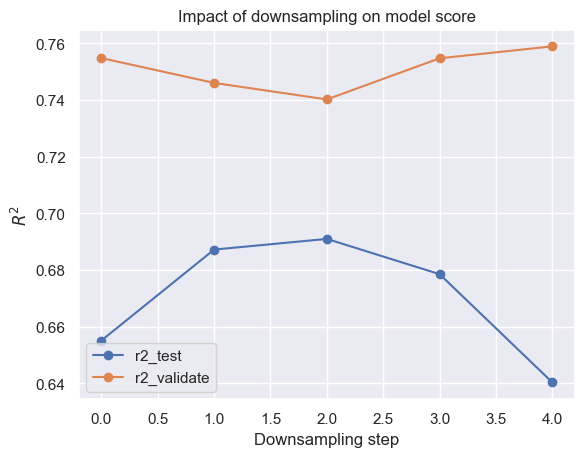

In [8]:
df_results.plot(y=['r2_test', 'r2_validate'], marker='o')
plt.title('Impact of downsampling on model score')
plt.xlabel('Downsampling step')
plt.ylabel('$R^2$')

### Downsampling minimum strategy

In [9]:
create_model_dir("downsampling_minimum_test")

In [10]:
from approaches.downsampling import get_downsampling_minimum

adata_sample = get_downsampling_minimum(adata,
                                        verbose=VERBOSE)

params_filename = os.path.join("models", "downsampling_minimum_test", f"autoencoder.pt")
create_and_train_vae_model(adata_sample,
                           epochs=EPOCHS,
                           save_params_to_filename=params_filename,
                           custom=USE_CUSTOM)

params_filename = params_filename if USE_CUSTOM else os.path.join(params_filename, "model.pt")
r2_downsampled, r2_diff_genes_downsampled = evaluate_r2(params_filename, adata, cell_type_to_predict=CELL_TYPE_TO_PREDICT)

print(f"R*2 downsampled: {r2_downsampled}")
print(f"R*2 diff downsampled: {r2_diff_genes_downsampled}")

Minimum cell type Dendritic with size: 463
Dataset size: 16893 cells
-------------------- 
 stimulated
NK 646 | 463 183
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
B 993 | 463 530
FCGR3A+Mono 2501 | 463 2038
CD14+Mono 615 | 463 152
CD8T 541 | 463 78
-------------------- 
 control
NK 517 | 463 54
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
B 818 | 463 355
FCGR3A+Mono 1100 | 463 637
CD14+Mono 1946 | 463 1483
CD8T 574 | 463 111
-------------------- 
 control
NK: 14.285714285714285%
Dendritic: 14.285714285714285%
CD4T: 14.285714285714285%
B: 14.285714285714285%
FCGR3A+Mono: 14.285714285714285%
CD14+Mono: 14.285714285714285%
CD8T: 14.285714285714285%
-------------------- 
 stimulated
NK: 14.285714285714285%
Dendritic: 14.285714285714285%
CD4T: 14.285714285714285%
B: 14.285714285714285%
FCGR3A+Mono: 14.285714285714285%
CD14+Mono: 14.285714285714285%
CD8T: 14.285714285714285%

Dataset sample size: 6482 cells
R*2 downsampled: 0.31493129566591677
R*2 diff downsampled: 0.31493129566591654


### Downsampling leave-one-out strategy

In [11]:
create_model_dir("downsampling_leave-one-out_test")

In [12]:
from approaches.downsampling import get_downsampling_minimum

exclude_cell_types = ["CD14+Mono", "B", "CD8T", "NK", "FCGR3A+Mono", "Dendritic"]

df_results = pd.DataFrame(data=np.zeros((len(exclude_cell_types), 2)), 
                          index=exclude_cell_types, 
                          columns=['r2', 'r2_diff_genes'])

for exclude_cell_type in exclude_cell_types:
    adata_sample = get_downsampling_minimum(adata,
                                            exclude_controlled_cell_type=exclude_cell_type,
                                            verbose=VERBOSE)

    params_filename = os.path.join("models", "downsampling_leave-one-out_test", f"{exclude_cell_type}_autoencoder.pt")
    create_and_train_vae_model(adata_sample,
                               epochs=EPOCHS,
                               save_params_to_filename=params_filename,
                               custom=USE_CUSTOM)

    params_filename = params_filename if USE_CUSTOM else os.path.join(params_filename, "model.pt")
    r2_downsampled, r2_downsampled_diff_genes = evaluate_r2(params_filename, adata, cell_type_to_predict=CELL_TYPE_TO_PREDICT)
    print(f"R*2 with {exclude_cell_type} excluded: {r2_downsampled}")
    print(f"R*2 diff downsampled with {exclude_cell_type} excluded: {r2_diff_genes_downsampled}")
    
    df_results.loc[exclude_cell_type, ['r2', 'r2_diff_genes']] = [r2_downsampled, r2_diff_genes_downsampled]

Minimum cell type Dendritic with size: 463
Dataset size: 16893 cells
-------------------- 
 stimulated
NK 646 | 463 183
Dendritic 463 | 463 0
CD4T 3127 | 463 2664
B 993 | 463 530
FCGR3A+Mono 2501 | 463 2038
CD14+Mono 0 | 0 0
CD8T 541 | 463 78
-------------------- 
 control
NK 517 | 463 54
Dendritic 615 | 463 152
CD4T 2437 | 463 1974
B 818 | 463 355
FCGR3A+Mono 1100 | 463 637
CD14+Mono 1946 | 463 1483
CD8T 574 | 463 111
-------------------- 
 control
NK: 14.285714285714285%
Dendritic: 14.285714285714285%
CD4T: 14.285714285714285%
B: 14.285714285714285%
FCGR3A+Mono: 14.285714285714285%
CD14+Mono: 14.285714285714285%
CD8T: 14.285714285714285%
-------------------- 
 stimulated
NK: 16.666666666666664%
Dendritic: 16.666666666666664%
CD4T: 16.666666666666664%
B: 16.666666666666664%
FCGR3A+Mono: 16.666666666666664%
CD14+Mono: 16.666666666666664%

Dataset sample size: 6019 cells
R*2 with CD14+Mono excluded: 0.3146175239395779
R*2 diff downsampled with CD14+Mono excluded: 0.31493129566591654
Min

Text(0, 0.5, '$R^2$')

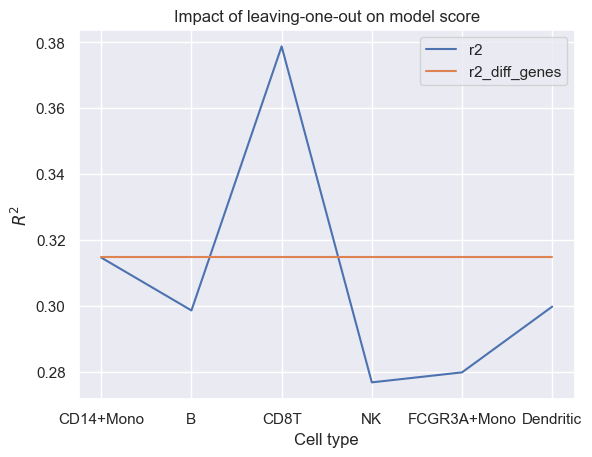

In [13]:
df_results.plot(y=['r2', 'r2_diff_genes'], kind='line')
plt.title('Impact of leaving-one-out on model score')
plt.xlabel('Cell type')
plt.ylabel('$R^2$')